# Kiani et al, Nature Methods 2014

This example reproduces Figure 2, part (a), from [Kiani et al, Nature Methods 11: 723 (2014)](http://www.nature.com/nmeth/journal/v11/n7/full/nmeth.2969.html).

In order to keep download sizes reasonable, the files only have about 10% of the original events.


### Experimental Layout

This experiment uses a dCas9 fusion to repress the output of a yellow fluorescent reporter.  The dCas9 is directed to the repressible promoter by a guide RNA under the control of rtTA3, a transcriptional activator controlled with the small molecule inducer doxycycline (Dox).

The plasmids that were co-transfected are shown below (reproduced from the above publication's Supplementary Figure 6a.)

![Genetic circuit](_images/kiani_circuit.png)

The experiment compares three different conditions:
 - No dCas9 / no gRNA
 - No gRNA
 - The full gene network
 
Each condition was induced with 0, 100, 500, and 4000 uM Dox.

In [1]:
import cytoflow as flow

# if your figures are too big or too small, you can scale them by changing matplotlib's DPI
import matplotlib
matplotlib.rc('figure', dpi = 160)

As is usual with `cytoflow`, we start by mapping the files to the experimental conditions.  We have three different conditions; four different Dox concentrations; and three replicates.

In [2]:
# (Condition, [Dox]) --> filename
inputs = {
    ("Full_Circuit", 0.0) : "Specimen_002_A1_A01.fcs",
    ("Full_Circuit", 100.0) : "Specimen_002_A2_A02.fcs",
    ("Full_Circuit", 500.0) : "Specimen_002_A3_A03.fcs",
    ("Full_Circuit", 4000.0) : "Specimen_002_A4_A04.fcs",
    ("No_gRNA", 0.0) : "Specimen_002_C5_C05.fcs",
    ("No_gRNA", 100.0) : "Specimen_002_C6_C06.fcs",
    ("No_gRNA", 500.0) : "Specimen_002_C7_C07.fcs",
    ("No_gRNA", 4000.0) : "Specimen_002_C8_C08.fcs",
    ("No_Cas9", 0.0) : "Specimen_002_D1_D01.fcs",
    ("No_Cas9", 100.0) : "Specimen_002_D2_D02.fcs",
    ("No_Cas9", 500.0) : "Specimen_002_D3_D03.fcs",
    ("No_Cas9", 4000.0) : "Specimen_002_D4_D04.fcs"}

tubes = []

for repl, path in {1 : "repl1", 2 : "repl2", 3 : "repl3"}.items():
    for (condition, dox), filename in inputs.items():
        tube = flow.Tube(file = path + "/" + filename,
                         conditions = {'Condition' : condition,
                                       'Dox' : dox,
                                       'Replicate' : repl})
        tubes.append(tube)

import_op = flow.ImportOp(conditions = {'Condition' : "category",
                                        'Dox' : "float",
                                        'Replicate' : "int"},
                          tubes = tubes)

ex = import_op.apply()

Have a look at the morphological parameters.

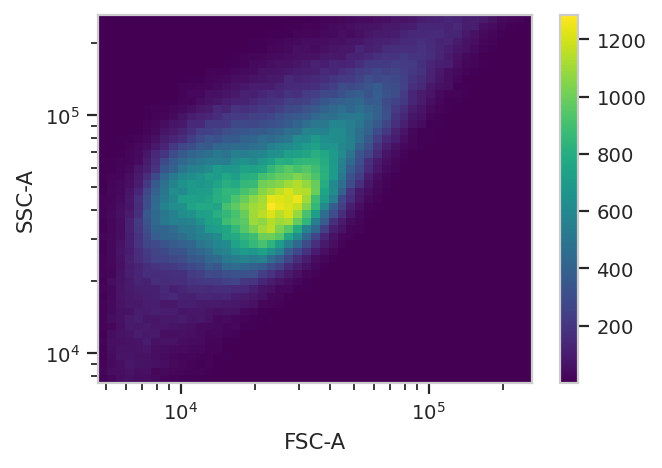

In [3]:
flow.DensityView(xchannel = "FSC-A", 
                 ychannel = "SSC-A",
                 xscale = 'log',
                 yscale = 'log').plot(ex, min_quantile = 0.005)

This looks like it's been pre-gated (ie, there's not a mixture of populations.)  It's also pushed up against the top axes in both SSC-A and FSC-A, which is a little concerning.  

Let's see how many events we're getting piled up.

In [4]:
(ex['SSC-A'] == ex['SSC-A'].max()).sum()

5434

Alright.  Some events (~5,000 out of 360,000) but not enough to be concerning.

The next thing we usually do is select for positively transfected cells.  mKate is the transfection marker, so look at the red channel.

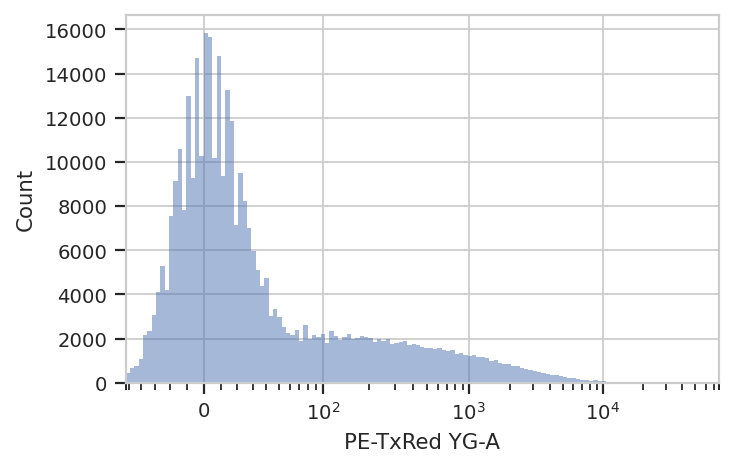

In [5]:
flow.HistogramView(channel = "PE-TxRed YG-A",
                   scale = 'logicle').plot(ex)

Let's fit a mixture-of-gaussians, for a nice principled way of separating the transfected population from the untransfected population.

/home/brian/src/cytoflow/cytoflow/operations/base_op_views.py:376: CytoflowViewWarning: Setting 'huefacet' to 'GM'


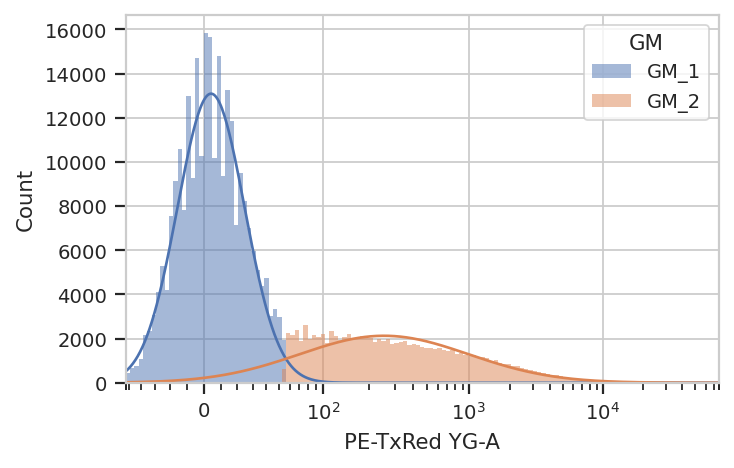

In [6]:
gm = flow.GaussianMixtureOp(name = "GM",
                            channels = ["PE-TxRed YG-A"],
                            scale = {'PE-TxRed YG-A' : 'logicle'},
                            num_components = 2)
gm.estimate(ex)
ex_gm = gm.apply(ex)
gm.default_view().plot(ex_gm)

Looks good: the events with `GM == 'GM_2'` are the cells in the transfected population. Let's see how many events were in each population.

In [7]:
ex_gm.data.groupby(['GM'], observed = True).size()

GM
GM_1    262010
GM_2     97990
dtype: int64

Let's make a new condition, `Transfected`, to be a boolean value with whether the cell was in `GM_2` or not. **Note: `add_condition` acts on the `Experiment` in-place.**

In [8]:
ex_gm.add_condition(name = 'Transfected', 
                    dtype = 'bool',
                    data = (ex_gm['GM'] == 'GM_2'))

Now, we can reproduce the bar chart in the publication by taking the output (EYFP, in the `FITC-A` channel) geometric mean of the positively transfected cells, split out by condition and [Dox].  Don't forget to look at just the *transfected* cells (using `subset`).  We'll compute the geometric mean across circuit and [Dox], and then split it out by replicate so we can compute the standard deviation of the means across samples.

*Please note:* This is a **terrible** way to use error bars.  See:

https://www.nature.com/nature/journal/v492/n7428/full/492180a.html

and

http://jcb.rupress.org/content/177/1/7

for reasons why.  I'm using them here to demonstrate the capability, rather than argue that you should perform your analysis this way. And the manipulation below is a little clunky -- maybe that's a good thing.

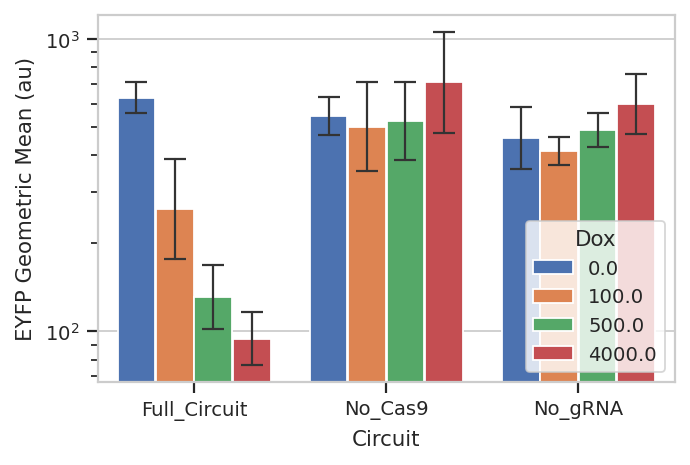

In [9]:
import pandas as pd
ex_stat = flow.ChannelStatisticOp(name = "FITC_mean",
                                  channel = "FITC-A",
                                  by = ["Condition", "Dox"],
                                  function = flow.geom_mean,
                                  subset = "Transfected == True").apply(ex_gm)

ex_stat = flow.ChannelStatisticOp(name = "FITC_mean_by_replicate",
                                  channel = "FITC-A",
                                  by = ["Condition", "Dox", "Replicate"],
                                  function = flow.geom_mean,
                                  subset = "Transfected == True").apply(ex_stat)

ex_stat = flow.TransformStatisticOp(name = "FITC_mean_sd",
                                    statistic = "FITC_mean_by_replicate",
                                    by = ["Condition", "Dox"],
                                    function = flow.geom_sd).apply(ex_stat)

# merge the stats using pandas ufuncs
df = pd.DataFrame({'Geo.Mean' : ex_stat.statistics['FITC_mean']["FITC-A"],
                   '*SD' : ex_stat.statistics['FITC_mean']["FITC-A"].multiply(ex_stat.statistics['FITC_mean_sd']["FITC-A"]),
                   '/SD' : ex_stat.statistics['FITC_mean']["FITC-A"].divide(ex_stat.statistics['FITC_mean_sd']["FITC-A"])})

# Experiment.statistics is just a dictionary mapping strings to pandas.DataFrames. no magic.
ex_stat.statistics['FITC_mean_and_sd'] = df
        
flow.BarChartView(statistic = "FITC_mean_and_sd",
                  feature = "Geo.Mean",
                  error_low = "/SD",
                  error_high = "*SD",
                  variable = "Condition",
                  scale = "log",
                  huefacet = "Dox").plot(ex_stat,
                                         xlabel = 'Circuit',
                                         ylabel = 'EYFP Geometric Mean (au)',
                                         capsize = 5,
                                         errwidth = 1)

So that's useful, but maybe there's more in this data.  When you transfect plasmids into mammalian cells, some cells get a lot of plasmids and some get comparatively few -- resulting in several orders of magnitude differences in transgene expression. We've noticed in our lab that gene circuit behavior frequently changes as copy number changes.  Is this the case here?  We can bin the data by transfection level, and see if the behavior changes as the bin number increases.  We can also ask that the number of events per bin be included as another piece of metadata, so we can exclude bins with a small number of events.

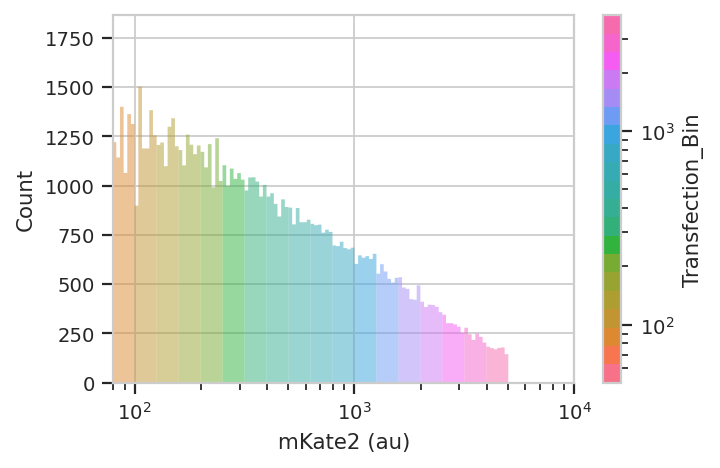

In [10]:
bin_op = flow.BinningOp(name = "Transfection_Bin",
                        channel = "PE-TxRed YG-A",
                        bin_width = 0.1,
                        scale = "log",
                        bin_count_name = "Transfection_Bin_Count") 

ex_bin = bin_op.apply(ex_gm)
flow.HistogramView(channel =  "PE-TxRed YG-A",
                   huefacet = "Transfection_Bin",
                   scale = 'log',
                   huescale = 'log',
                   subset = "Transfected == True & "
                            "Transfection_Bin_Count > 1000").plot(ex_bin, 
                                                                  lim = (80, 10000),
                                                                  xlabel = 'mKate2 (au)')

Now repeat the above analysis, but as a line plot with transfection bin on the X-axis and mean FITC output on the Y-axis -- pretty much just adding ``Transfection_Bin`` to the ``by`` attribute, and making sure only to include bins with more than 500 events.

/home/brian/src/cytoflow/cytoflow/operations/channel_stat.py:217: CytoflowOpWarning: No events for category ['Condition=Full_Circuit', 'Dox=100.0', 'Replicate=1', 'Transfection_Bin=3981.0']
/home/brian/src/cytoflow/cytoflow/operations/channel_stat.py:217: CytoflowOpWarning: No events for category ['Condition=Full_Circuit', 'Dox=500.0', 'Replicate=3', 'Transfection_Bin=5012.0']
/home/brian/src/cytoflow/cytoflow/operations/channel_stat.py:217: CytoflowOpWarning: No events for category ['Condition=Full_Circuit', 'Dox=4000.0', 'Replicate=1', 'Transfection_Bin=5012.0']
/home/brian/src/cytoflow/cytoflow/operations/channel_stat.py:217: CytoflowOpWarning: No events for category ['Condition=Full_Circuit', 'Dox=4000.0', 'Replicate=1', 'Transfection_Bin=3981.0']
/home/brian/src/cytoflow/cytoflow/operations/channel_stat.py:217: CytoflowOpWarning: No events for category ['Condition=Full_Circuit', 'Dox=4000.0', 'Replicate=3', 'Transfection_Bin=5012.0']


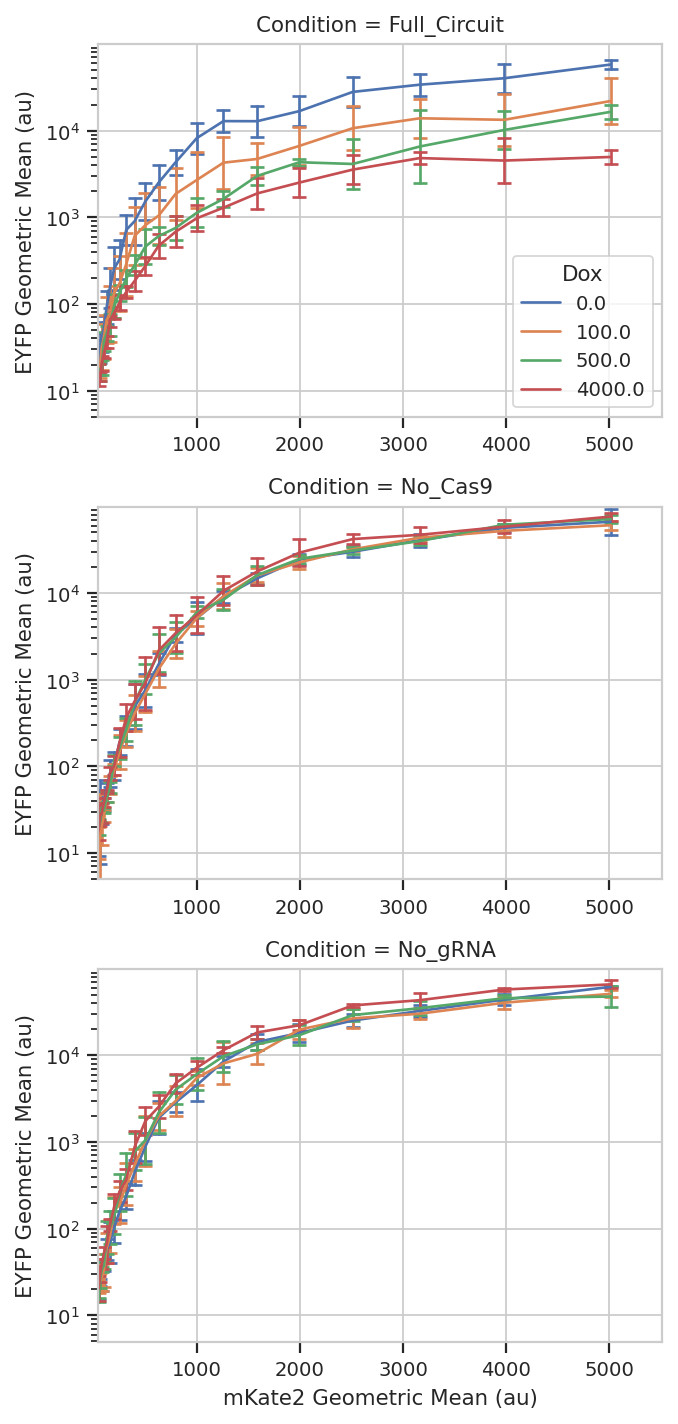

In [11]:
ex_stat = flow.ChannelStatisticOp(name = "FITC_mean",
                                  channel = "FITC-A",
                                  by = ["Condition", "Dox", "Transfection_Bin"],
                                  function = flow.geom_mean,
                                  subset = "Transfected == True &"
                                           "Transfection_Bin_Count > 500",
                                  fill = 0).apply(ex_bin)

ex_stat = flow.ChannelStatisticOp(name = "FITC_mean_by_replicate",
                                  channel = "FITC-A",
                                  by = ["Condition", "Dox", "Replicate", "Transfection_Bin"],
                                  function = flow.geom_mean,
                                  subset = "Transfected == True &"
                                           "Transfection_Bin_Count > 500", 
                                  fill = 0).apply(ex_stat)

ex_stat = flow.TransformStatisticOp(name = "FITC_mean_sd",
                                    statistic = "FITC_mean_by_replicate",
                                    by = ["Condition", "Dox", "Transfection_Bin"],
                                    function = flow.geom_sd).apply(ex_stat)

# merge the stats using pandas ufuncs
df = pd.DataFrame({'Geo.Mean' : ex_stat.statistics['FITC_mean']["FITC-A"],
                   '*SD' : ex_stat.statistics['FITC_mean']["FITC-A"].multiply(ex_stat.statistics['FITC_mean_sd']["FITC-A"]),
                   '/SD' : ex_stat.statistics['FITC_mean']["FITC-A"].divide(ex_stat.statistics['FITC_mean_sd']["FITC-A"])})

# Experiment.statistics is just a dictionary mapping strings to pandas.DataFrames. no magic.
ex_stat.statistics['FITC_mean_and_sd'] = df

flow.Stats1DView(statistic = "FITC_mean_and_sd",
                 variable = "Transfection_Bin",
                 feature = "Geo.Mean",
                 error_low = "/SD",
                 error_high = "*SD",
                 huefacet = "Dox",
                 variable_scale = 'linear',
                 scale = 'log',
                 yfacet = "Condition").plot(ex_stat,
                                            xlabel = 'mKate2 Geometric Mean (au)',
                                            ylabel = 'EYFP Geometric Mean (au)',
                                            sharex = False,
                                            capsize = 3)